# Convolutional neural networks

## The convolution operation

Convolutional neural networks make use of the convolution operation. They are mostly used for processing image data with 2D discrete convolutions:

![convolution](figures/convolution.png)

## Let's try it out
Can you guess what the output image for convolutional kernel in the picture above will look like?

It's the Sobel operator (https://en.wikipedia.org/wiki/Sobel_operator) that can be used for edge detection

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

In [5]:
img = np.load("grumpy.npy")

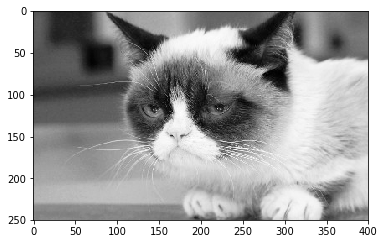

In [6]:
plt.imshow(img, cmap="Greys_r")

We could use `scipy.signal` to perform the convolution operation but to understand how the convolution works, let's quickly implement it by manually scanning over the image:

In [7]:
def convolve(img, kernel):
    output_array = np.empty(shape=(img.shape[0]-2, img.shape[1]-2))
    for j in range(output_array.shape[1]):
        for i in range(output_array.shape[0]):
            output_array[i][j] = np.dot(
                kernel.reshape(-1),
                img[i:i+kernel.shape[0], j:j+kernel.shape[1]].reshape(-1)
            )
    return output_array

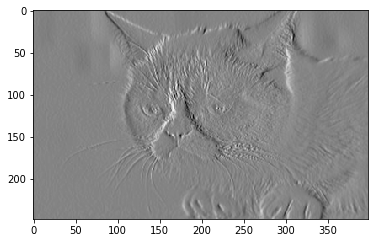

In [8]:
plt.imshow(convolve(img, sobel_x), cmap="Greys_r")

Vertical edges got highlighted! In a very simple example:

In [22]:
test_img = np.array([
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
])

In [23]:
convolve(test_img, sobel_x)

array([[ 0.,  0.,  4.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  4.,  0.,  0.]])

The transposed filter will highlight horizontal edges:

In [9]:
sobel_y = sobel_x.T
sobel_y

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

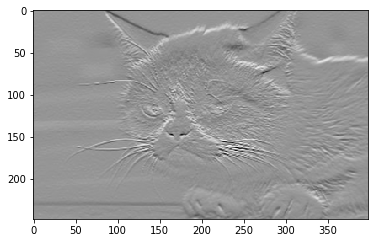

In [10]:
plt.imshow(convolve(img, sobel_y), cmap="Greys_r")

And if we take the square root of the squared sum of the pictures above we get a nice highlighting of all edges:

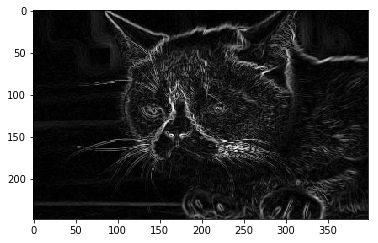

In [9]:
plt.imshow(
    np.sqrt(
        convolve(img, sobel_x)**2
        + convolve(img, sobel_y)**2
    ),
    cmap="Greys_r"
)

## Application within a neural network

You might imagine that such filters help a lot when processing images and e.g. trying to learn what they show. What a convolutional neural network (CNN) does is instead of using hand-designed filters have them as trainable parameters. We can then have layers with arbitrary many input features (each of them an image) and arbitrary many output features (each of them as well an image) by essentially sliding a neural network over them:

![cnn_layer](figures/cnn_layer.png)

The top row corresponds to the input features - before the first layer these are typically the 3 colors, red, green, blue and the bottom row corresponds to the output features. For each output feature, the neutral network will learn one convolutional kernel for each input feature. So the black lines in the graphic above correspond to the trainable weights.

[animated version](https://homepages.physik.uni-muenchen.de/~Nikolai.Hartmann/cnn_anim.svg)

In Addition to applying the filter one can (and typically will) also apply an activation function.

## Pooling layers

In addition to convolutional layers, CNNs will typically perform some kind of downsampling in between. This has several reasons:

- The region of the orgininal image that the neural network can "see" will increase. This can help to make use of correlations between more distant areas within an image
- The amount of computation decreases (smaller images further down in the network) - more depth and/or width of the network can be increased
- Especially for classification problems the total NN output should a few numbers, e.g. indicating in which category an image falls. Successively downsampling the image within the network will help to keep the number of parameters in the last layers small.

Pooling typically takes the maximum, average or sum over a fixed sliding window. For exmaple Max pooling with a 2x2 window:

![max_pooling](figures/Max_pooling.png)


## Full CNN Architecture for image classification

A typical CNN architecture for image classification consists of several convolutional layers with pooling layers in between an a simple fully-connected network as a last step:

![max_pooling](figures/Typical_cnn.png)

The fully connected network either has all output pixels of the last convolutional/pooling layer as input ("flatten") or uses the global average of each output feature of the last convolutional/pooling layer

## Lets try it out - CIFAR10